### Stock Trading Strategy using Classification Algorithms to Predict Market Movements and Backtesting

In [242]:

%load_ext autoreload
%autoreload 2
# make the necessary imports 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import warnings
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import pyfolio as pf # install with pip install git+ssh://git@github.com/giocaizzi/pyfolio.git
import warnings

from surfingcrypto import Config,TS
from surfingcrypto.algotrading.objects import BackTest

# set the style and ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Gathering

In [243]:
c = Config("/Users/giorgiocaizzi/Documents/GitHub/surfingcrypto/config")
ticker = "ETH"
ts = TS(c, coin=ticker)
ts.df


,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2017-10-01 00:00:00+00:00,255.288687,256.747390,249.797667,256.044212,2.593030e+08,2.430109e+10
2017-10-02 00:00:00+00:00,256.167001,256.711876,250.857533,253.580263,2.893556e+08,2.407106e+10
2017-10-03 00:00:00+00:00,253.587078,256.395551,245.386642,248.989454,2.738634e+08,2.363906e+10
2017-10-04 00:00:00+00:00,249.237185,254.456920,247.380720,248.964687,2.194011e+08,2.364053e+10
2017-10-05 00:00:00+00:00,249.062535,254.518348,245.716713,252.593705,2.166371e+08,2.398902e+10
...,...,...,...,...,...,...
2022-04-19 00:00:00+00:00,2836.168541,2897.900089,2812.086318,2875.371120,1.311291e+10,3.463310e+11
2022-04-20 00:00:00+00:00,2875.212216,2916.149561,2808.830817,2836.684469,1.432963e+10,3.417094e+11
2022-04-21 00:00:00+00:00,2836.761462,2915.710028,2734.503187,2757.319204,1.918238e+10,3.321855e+11


In [244]:
stock = ts.df[["Close"]]
stock.rename(columns={"Close": ticker}, inplace=True)
# calculate daily log returns and market direction
stock["returns"] = np.log(stock / stock.shift(1))
stock.dropna(inplace=True)
stock["direction"] = np.sign(stock["returns"]).astype(int)
stock.tail(2)


,ETH,returns,direction
Date,,,
2022-04-22 00:00:00+00:00,2748.604222,-0.003166,-1
2022-04-23 00:00:00+00:00,2723.831464,-0.009054,-1


### Feature Engineering

In [245]:
# function to transform the lag returns to binary values (0,+1)
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + "_bin"
        data[col_bin] = np.digitize(data[col], bins=bins)
        cols_bin.append(col_bin)


In [246]:
# define the number of lags
lags = [1, 2, 3, 4, 5]

# compute lagged log returns
cols = []
for lag in lags:
    col = f"rtn_lag{lag}"
    stock[col] = stock["returns"].shift(lag)
    cols.append(col)

stock.dropna(inplace=True)
create_bins(stock)
stock.tail(2)


,ETH,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rtn_lag1_bin,rtn_lag2_bin,rtn_lag3_bin,rtn_lag4_bin,rtn_lag5_bin
Date,,,,,,,,,,,,,
2022-04-22 00:00:00+00:00,2748.604222,-0.003166,-1,-0.028377,-0.013546,0.013716,0.024265,-0.022907,0,0,1,1,0
2022-04-23 00:00:00+00:00,2723.831464,-0.009054,-1,-0.003166,-0.028377,-0.013546,0.013716,0.024265,0,0,0,1,1


### Build and Apply Classification Machine Learning Algorithms

Select Logistic regression, Gaussian Naive Bayes, Support Vector Machine, Random Forest, and MLP Classifier approaches to predict the market direction. Please refer sklearn documentation for detail on these and other algorithms.
https://scikit-learn.org/stable/index.html

In [247]:
# create a dictionary of selected algorithms
models = {
    "log_reg": linear_model.LogisticRegression(),
    "gauss_nb": GaussianNB(),
    "svm": SVC(),
    "random_forest": RandomForestClassifier(max_depth=10, n_estimators=100),
    "MLP": MLPClassifier(max_iter=500),
}


In [248]:
# function that fits all models.
def fit_models(data):
    mfit = {
        model: models[model].fit(data[cols_bin], data["direction"])
        for model in models.keys()
    }



In [249]:
# function that predicts (derives all position values) from the fitted models
def estimate_positions(data):
    for model in models.keys():
        data["pos_" + model] = models[model].predict(data[cols_bin])



In [250]:
# function to evaluate all trading strategies
def evaluate_strats(data):
    global strategy_rtn
    strategy_rtn = []
    for model in models.keys():
        col = "strategy_" + model
        data[col] = data["pos_" + model] * data["returns"]
        strategy_rtn.append(col)
    strategy_rtn.insert(0, "returns")



In [251]:
# fit the models
fit_models(stock)
# estimate
estimate_positions(stock)


In [252]:
## BACKTESTING NUMERICALLY

# evaluate all trading strategies by multiplying predicted directions to actual daily returns
evaluate_strats(stock)
# calculate total return and std. deviation of each strategy
print("\nTotal Returns:")
print(stock[strategy_rtn].sum().apply(np.exp))
print("\nAnnual Volatility:")
stock[strategy_rtn].std() * 252 ** 0.5



Total Returns:
returns                   10.356434
strategy_log_reg           0.326255
strategy_gauss_nb          0.439645
strategy_svm              33.152300
strategy_random_forest     7.883281
strategy_MLP               0.386983
dtype: float64

Annual Volatility:


returns                   0.813522
strategy_log_reg          0.813759
strategy_gauss_nb         0.813792
strategy_svm              0.813140
strategy_random_forest    0.813590
strategy_MLP              0.813779
dtype: float64

### Strategy evalutation using Backtrader

Strategy: 
1.	Buy when the predicted value is +1 and sell (only if stock is in possession) when the predicted value is -1.
2.	All-in strategy—when creating a buy order, buy as many shares as possible.
3.	Short selling is not allowed

In [253]:
start = "2022-01-01"

performance = {}
backtests = {}
for key in models.keys():
    prices = ts.df[["Open", "High", "Low", "Close", "Volume"]]
    prices = prices.loc[start:]
    prices.rename(
        columns={
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Volume": "volume",
        },
        inplace=True,
    )
    # add the predicted column to prices dataframe. right joining them so to start from backtesting startdate.
    predictions = stock[["strategy_" + key]]
    predictions.rename(columns={"strategy_" + key: "predicted"}, inplace=True)
    prices = predictions.join(prices, how="right").dropna()

    # run
    i_backtest = BackTest(prices, ticker,verbose=False)
    i_backtest.run()
    backtests[key] = i_backtest
    performance[key] = i_backtest.performance_stats()
performance = pd.DataFrame(performance)



In [254]:
performance


,log_reg,gauss_nb,svm,random_forest,MLP
Annual return,-0.597710,-0.673152,-0.550502,-0.645122,-0.555348
Cumulative returns,-0.335231,-0.394344,-0.301319,-0.371580,-0.304707
Annual volatility,0.402480,0.394700,0.375251,0.399546,0.395756
Sharpe ratio,-2.058907,-2.631949,-1.941232,-2.388536,-1.848626
Calmar ratio,-1.762068,-1.691475,-1.576235,-1.718764,-1.798013
Stability,0.824197,0.919023,0.837286,0.879560,0.780955
Max drawdown,-0.339209,-0.397968,-0.349251,-0.375340,-0.308868
Omega ratio,0.660737,0.579844,0.664818,0.613788,0.685723
Sortino ratio,-2.738711,-3.469483,-2.566612,-3.057106,-2.498095
Skew,0.310723,0.578638,0.191330,0.031706,0.336843


## Choose best model from backtesting results

Choose the one with the greates cumulative returns.

In [255]:
print(performance.loc["Cumulative returns"].idxmax())
backtest = backtests[performance.loc["Cumulative returns"].idxmax()]



svm


In [256]:
backtest.print_log()


2022-01-02, Open: 3313.975, Close: 3367.268
2022-01-02,     BUY CREATED --- Size: 0.373, Price: 3314.325, Cost: 1237.500
2022-01-02,     BUY EXECUTED --- Size: 0.373, Price: 3313.975, Cost: 1237.369, Commission: 12.374
2022-01-05, Open: 3362.766, Close: 3138.972
2022-01-05,     SELL CREATED --- Size: -0.373, Price: 3362.578, Cost: -1255.516
2022-01-05,     SELL EXECUTED --- Size: -0.373, Price: 3362.766, Cost: -1255.587, Commission: 12.556
2022-01-05,          -> OPERATION RESULT --- Gross: 18.218, Net: -6.712
2022-01-11, Open: 2721.103, Close: 2848.936
2022-01-11,     BUY CREATED --- Size: 0.452, Price: 2721.198, Cost: 1230.855
2022-01-11,     BUY EXECUTED --- Size: 0.452, Price: 2721.103, Cost: 1230.812, Commission: 12.308
2022-01-15, Open: 2899.480, Close: 2917.602
2022-01-15,     SELL CREATED --- Size: -0.452, Price: 2899.618, Cost: -1311.558
2022-01-15,     SELL EXECUTED --- Size: -0.452, Price: 2899.480, Cost: -1311.496, Commission: 13.115
2022-01-15,          -> OPERATION RESULT

# Plotting

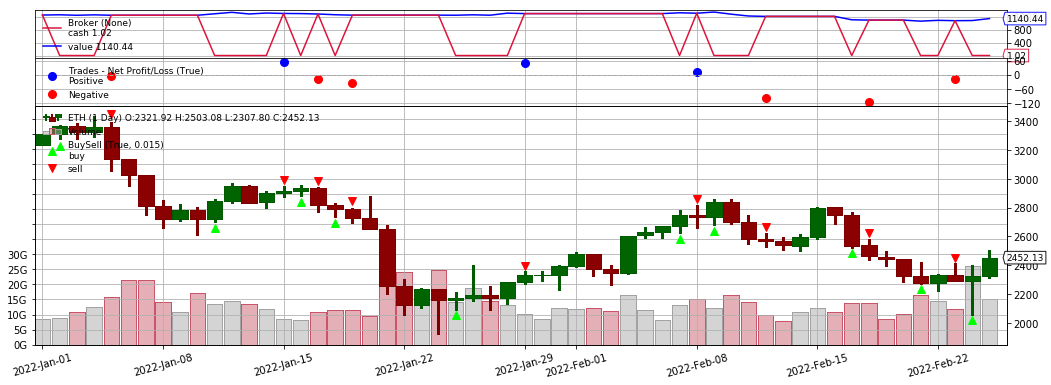

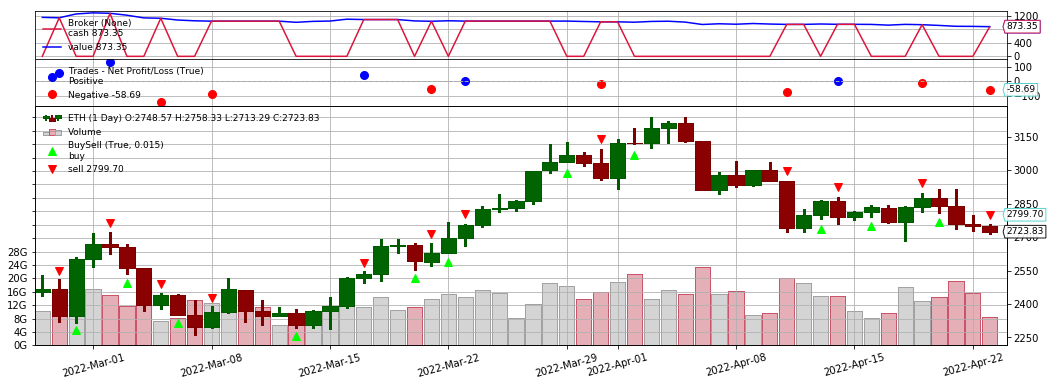

In [257]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [15, 5]
figs = backtest.cerebro.plot(
    style="candlesticks",
    barup="darkgreen",
    bardown="darkred",
    numfigs=2,
    iplot=False,
    fmt_x_ticks="%Y-%b-%d",
)



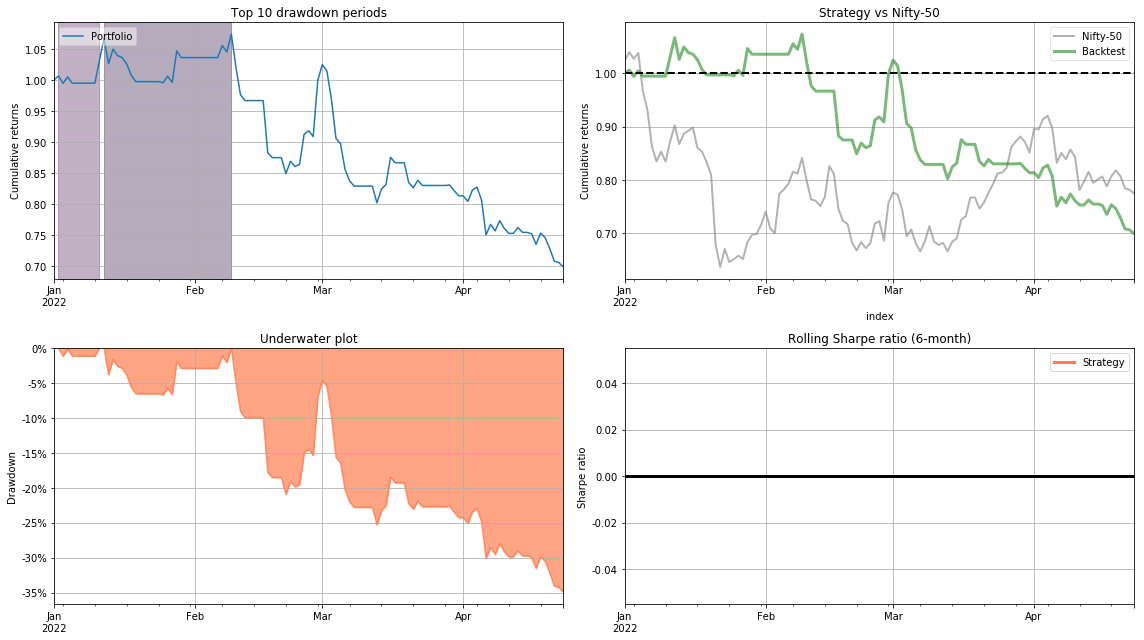

In [258]:
# plot performance for strategy vs benchmark

# get benchmark returns # just buy and hold
benchmark_rets = stock["returns"]
benchmark_rets = benchmark_rets.filter(backtest.returns.index)
benchmark_rets.name = "Nifty-50"
benchmark_rets.tail()


fig, ax = plt.subplots(
    nrows=2, ncols=2, figsize=(16, 9), constrained_layout=True
)
axes = ax.flatten()

pf.plot_drawdown_periods(returns=backtest.returns, ax=axes[0])
axes[0].grid(True)
pf.plot_rolling_returns(
    returns=backtest.returns,
    factor_returns=benchmark_rets,
    ax=axes[1],
    title="Strategy vs Nifty-50",
)
axes[1].grid(True)
pf.plot_drawdown_underwater(returns=backtest.returns, ax=axes[2])
axes[2].grid(True)
pf.plot_rolling_sharpe(returns=backtest.returns, ax=axes[3])
axes[3].grid(True)
# fig.suptitle('Strategy vs Nifty-50 (Buy and Hold)', fontsize=16, y=0.990)

plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig('images/chart3', dpi=300)


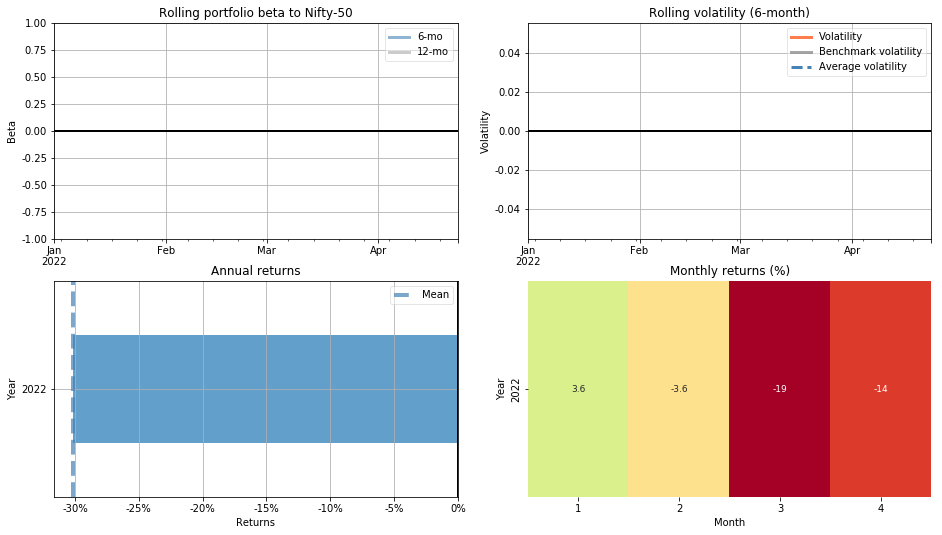

In [259]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(
    nrows=2, ncols=2, figsize=(16, 9), constrained_layout=True
)
axes = ax.flatten()

pf.plot_rolling_beta(
    returns=backtest.returns, factor_returns=benchmark_rets, ax=axes[0]
)
axes[0].grid(True)

pf.plot_rolling_volatility(
    returns=backtest.returns, factor_returns=benchmark_rets, ax=axes[1]
)
axes[1].grid(True)

pf.plot_annual_returns(returns=backtest.returns, ax=axes[2])
axes[2].grid(True)

pf.plot_monthly_returns_heatmap(
    returns=backtest.returns, ax=axes[3],
)
# fig.suptitle('BL Portfolio vs BSE-SENSEX - 2', fontsize=16, y=1.0)


plt.tight_layout()
# plt.savefig('images/chart4', dpi=300)


# Apply to future

In [260]:
# apply to future

print(stock.iloc[-1].name)

future = stock.iloc[-1, 3:8].shift(1)
future.loc["rtn_lag1"] = 0.05
future = pd.DataFrame(future).T
create_bins(future)
future
future

models["svm"].predict(future[cols_bin].to_numpy().reshape(1, -1))


2022-04-23 00:00:00+00:00


array([-1])